In [1]:
# https://george.readthedocs.io/en/latest/tutorials/first/

In [2]:
import george
george.__version__

'0.3.1'

In [3]:
import glob

In [17]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [30]:
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

In [6]:
np.random.seed(1234)
x = 10 * np.sort(np.random.rand(15))
yerr = 0.2 * np.ones_like(x)
y = np.sin(x) + yerr * np.random.randn(len(x))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y");
# plt.show()
# plt.close()

In [7]:
from george import kernels

kernel = np.var(y) * kernels.ExpSquaredKernel(0.5)
gp = george.GP(kernel)
gp.compute(x, yerr)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

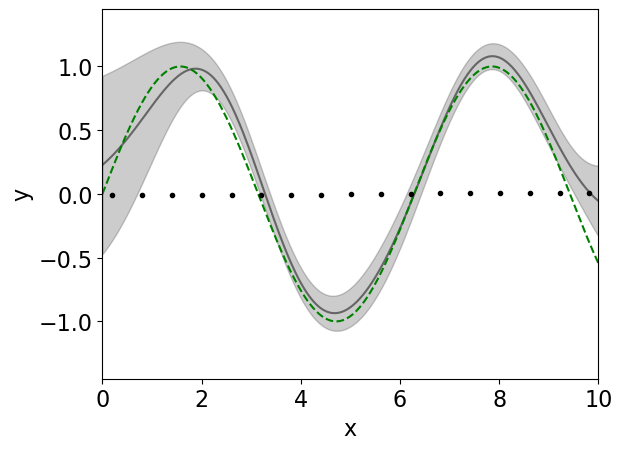

In [31]:
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y");
# plt.show()
# plt.close()

In [9]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -11.82


In [10]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: 9.225282556043899
 hess_inv: array([[0.52320809, 0.30041273],
       [0.30041273, 0.40708074]])
      jac: array([-5.07047662e-06,  2.56077807e-06])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 8
     njev: 10
   status: 0
  success: True
        x: array([-0.48730733,  0.60407551])

Final ln-likelihood: -9.23


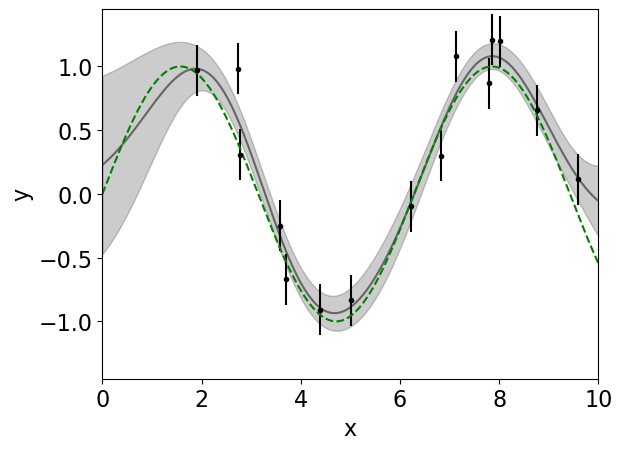

In [11]:
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y");
plt.show()
plt.close()

# try fitting NR

In [12]:
import h5py
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom

In [13]:
def match(h1, h2, times):
        
    dt = times[1] - times[0]
    n = len(times)
    df = 1.0/(n*dt)
    norm = 4. * df
    
    h1_fft = np.fft.fft(h1)
    h2_fft = np.fft.fft(h2)
    
    h1h1_sq = np.vdot(h1_fft, h1_fft) * norm
    h2h2_sq = np.vdot(h2_fft, h2_fft) * norm
    
    h1h1 = dt * np.sqrt(h1h1_sq)
    h2h2 = dt * np.sqrt(h2h2_sq)
    

    ifft = np.fft.ifft(np.conj(h1_fft) * h2_fft)
    
    return ifft / h1h1 / h2h2 * 4 * dt

In [14]:
def max_match(h1, h2, times):
    m = match(h1, h2, times)
    max_idx = np.argmax(np.abs(m))
    return np.abs(m[max_idx])

In [15]:
def mass1_from_mtotal_eta(mtotal, eta):
    """Returns the primary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 + (1.0 - 4.0 * eta)**0.5)


def mass2_from_mtotal_eta(mtotal, eta):
    """Returns the secondary mass from the total mass and symmetric mass
    ratio.
    """
    return 0.5 * mtotal * (1.0 - (1.0 - 4.0 * eta)**0.5)


def eta_from_q(q):
    """
    converts mass-ratio to symmetric mass-ratio
    input: q
    output: eta
    """
    return q/(1.+q)**2

In [16]:
from positive.physics import cw181003550
import phenom
def get_remnant(eta, ell, mm):
    fin_spin = phenom.remnant.FinalSpin0815(eta, 0, 0)
    final_mass = 1.0 - phenom.EradRational0815(eta, 0, 0)
    
    complex_rd = cw181003550(fin_spin, ell, mm, 0)
    omega_rd = np.real(complex_rd) / final_mass
    tdamp_rd = np.imag(complex_rd) / final_mass
    
    return omega_rd, 1./tdamp_rd

(positive)>> Applying custom matplotlib settings.


In [269]:
class MultiModeNRWaveform(object):
    def __init__(self, nrfile, ell_mm_list, npts, t1=-600, t2=60):
        """
        ell_mm_list e.g. [(2,2), (3,2)]
        """

        self.nrfile = nrfile
        self.npts = npts
        self.t1=t1
        self.t2=t2
        self.ell_mm_list = ell_mm_list

        self.times = np.linspace(self.t1, self.t2, self.npts)
        
        self.get_lm_modes(self.nrfile, self.ell_mm_list, self.npts)


    def get_lm_modes(self, nrfile, ell_mm_list, npts):
        
        self.hlms = {}
        
        for ell, mm in ell_mm_list:

            if 'SXS' in nrfile:
                f = h5py.File(nrfile, 'r')

                self.q = f.attrs['mass1']/f.attrs['mass2']
                self.eta = f.attrs['eta']

                amp_tmp = f['amp_l{0}_m{1}'.format(ell, mm)]
                amp_x = amp_tmp['X'][:]
                amp_y = amp_tmp['Y'][:]

                phase_tmp = f['phase_l{0}_m{1}'.format(ell, mm)]
                phase_x = phase_tmp['X'][:]
                phase_y = phase_tmp['Y'][:]

                f.close()
            elif 'Sur' in nrfile:
                f = h5py.File(nrfile, 'r')
                self.q = f.attrs['q']
                self.mtot = 1
                self.eta = phenom.eta_from_q(self.q)
                mass1, mass2 = phenom.utils.m1_m2_M_q(self.mtot, self.q)
                
                if (ell == 2) & (mm == 2):
                    times, re_hlm, im_hlm = f['data22'][:].T
                elif (ell == 3) & (mm == 2):
                    times, re_hlm, im_hlm = f['data32'][:].T
                
                # SIGN CONVENTION HERE NOTE SURE WHAT IS CORRECT FOR BAM
                hlm = re_hlm + 1.j * im_hlm

                amp_x = times
                amp_y = np.abs(hlm)

                phase_x = times
                phase_y = np.unwrap(np.angle(hlm))
                f.close()
                
                
            else:
                # bam
                self.sim_dir = os.path.dirname(nrfile)
                self.bbh_file = glob.glob( os.path.join(self.sim_dir, '*.bbh') )[0]
                # strict=False because of DuplicateSectionError
                config = configparser.ConfigParser(strict=False)

                config.read(self.bbh_file)
                mass1_tmp = float(config['metadata']['mass1'])
                mass2_tmp = float(config['metadata']['mass2'])
                self.initial_sep = float(config['metadata']['initial-separation'])

                if mass1_tmp >= mass2_tmp:
                    mass1 = mass1_tmp
                    mass2 = mass2_tmp
                else:
                    mass1 = mass2_tmp
                    mass2 = mass1_tmp


                self.mass1 = mass1
                self.mass2 = mass2
                self.mtot = self.mass1 + self.mass2
                self.q = self.mass1 / self.mass2
                self.eta = self.mass1 * self.mass2 / (self.mtot)**2.

                times, re_hlm, im_hlm = np.loadtxt(nrfile, unpack=True)

                # SIGN CONVENTION HERE NOTE SURE WHAT IS CORRECT FOR BAM
                hlm = re_hlm - 1.j * im_hlm

                amp_x = times
                amp_y = np.abs(hlm)

                phase_x = times
                phase_y = np.unwrap(np.angle(hlm))


            if (ell == 2) & (mm == 2):
                # shift so that amp peak is at t=0 - will need to be more careful with HMs
                amp_peak_idx_22 = amp_y.argmax()
                amp_peak_time_22 = amp_x[amp_peak_idx_22]
                amp_x = amp_x - amp_peak_time_22
                phase_x = phase_x - amp_peak_time_22
            else:
                amp_x = amp_x - amp_peak_time_22
                phase_x = phase_x - amp_peak_time_22


            amp_i = IUS(amp_x, amp_y)
            phase_i = IUS(phase_x, phase_y)          

            amplist = amp_i(self.times)
            
            # align phase s.t. at t=10 after peak of 22 stran the phase is zeri
#             phi_0 = phase_i(10)
#             phase_i = IUS(phase_x, phase_y - phi_0)
            phaselist = phase_i(self.times)
            
            freqlist = phase_i.derivative()(self.times)

            
            amp = amplist
            phi = phaselist
            freq = freqlist
            hlm = amp * np.exp(-1.j * phi)
            
            hlm_dict = {
                'times':self.times,
                'amp':amp,
                'phi':phi,
                'hlm':hlm,
                'freq':freq
            }
            
            self.hlms.update({(ell,mm):hlm_dict})
            
        eta, chi1z, chi2z = self.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
        
        self.om22, self.tau22 = get_remnant(eta, 2, 2)
        self.om32, self.tau32 = get_remnant(eta, 3, 2)
        self.om22 = -self.om22
        self.om32 = -self.om32

    def resample_data(self, new_time_array):
        """
        new_time_array : numpy.array

        redefines the amp, phi and hlm attributes to be sampled on
        the new_time_array
        """
        amp_i = IUS(self.times, self.amp)
        phi_i = IUS(self.times, self.phi)

        self.npts = len(new_time_array)
        self.times = new_time_array
        self.amp = amp_i(new_time_array)
        self.phi = phi_i(new_time_array)
        self.hlm = self.amp * np.exp(-1.j * self.phi)


In [270]:
# if you want to add surrogate data then set this
USE_SUR_DATA = True
sur_data_files = sorted(glob.glob('/Users/spx8sk/work/git/chirpy-mk1/issues/gen-sur-data/data/*'))

sur_keys = [sur.split('/')[-1].split('.h5')[0].split('_')[-1].replace(".","p") for sur in sur_data_files]

sur_dict_files = {}
[sur_dict_files.update({sur_keys[i]:sur_data_files[i]}) for i in range(len(sur_keys))];

In [271]:
sur_keys

['q1p0',
 'q1p2',
 'q1p4',
 'q1p6',
 'q1p8',
 'q2p0',
 'q2p2',
 'q2p4',
 'q2p6',
 'q2p8',
 'q3p0',
 'q3p2',
 'q3p4',
 'q3p6',
 'q3p8',
 'q4p0',
 'q4p2',
 'q4p4',
 'q4p6',
 'q4p8',
 'q5p0',
 'q5p2',
 'q5p4',
 'q5p6',
 'q5p8',
 'q6p0',
 'q6p2',
 'q6p4',
 'q6p6',
 'q6p8',
 'q7p0',
 'q7p2',
 'q7p4',
 'q7p6',
 'q7p8']

In [272]:
nrfiles = dict(
        q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
        q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
        q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
        q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
        q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5'
    )





# nrfiles = dict(
#         q1='/Users/spx8sk/work/data/SXS_BBH_0180_Res4.h5',
#         q2='/Users/spx8sk/work/data/SXS_BBH_0169_Res5.h5',
#         q4='/Users/spx8sk/work/data/SXS_BBH_0167_Res5.h5',
#         q5='/Users/spx8sk/work/data/SXS_BBH_0107_Res5.h5',
#         q10='/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5',
#         q18="/Users/spx8sk/work/git/stk/ml/waveforms/bob/q18a0a0c025_144-22-hybrid.h5",
#     )

# nrfiles = dict(
#     q10_3 = '/Users/spx8sk/work/data/SXS_BBH_0303_Res3.h5',
#     q10_4 = '/Users/spx8sk/work/data/SXS_BBH_0303_Res4.h5',
#     q10_5 = '/Users/spx8sk/work/data/SXS_BBH_0303_Res5.h5'
# )


ell_mm_list = [(2,2),(3,2)]
# ell_mm_list = [(2,2)]
# npts_time = 1000*4
npts_time = 500

# t1=-600
t1=-100
# t1=-3000
t2=100


if USE_SUR_DATA:
    nrfiles.update(sur_dict_files)
    t1=-200


nrdatas = {}

for k in nrfiles.keys():
    nrfile = nrfiles[k]
    nrdatas.update({k:MultiModeNRWaveform(nrfile, ell_mm_list, npts_time, t1=t1,t2=t2)})

In [305]:
mode = (3,2)
k='q4'
x = nrdatas[k].hlms[mode]['times']
# y = nrdatas[k].hlms[mode]['amp']
# y = nrdatas[k].hlms[mode]['phi']
y = np.real(nrdatas[k].hlms[mode]['hlm'])
# y = nrdatas[k].hlms[mode]['freq']


yerr = np.zeros_like(y) + 1e-5

(-100, 100)

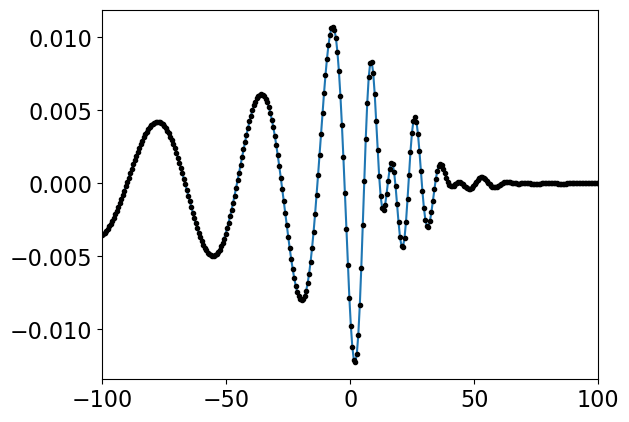

In [306]:
plt.figure()
plt.plot(x, y)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlim(-100,100)

In [297]:
kernel.check_parameter_vector

<bound method Model.check_parameter_vector of ConstantKernel(log_constant=-11.68663138466773, ndim=1, axes=array([0])) * ExpSquaredKernel(metric=Metric(7.297423687096858, ndim=1, axes=array([0]), bounds=[(None, None)]), block=None)>

In [298]:
3.0781441905112312**2

9.474971657578044

In [299]:
from george import kernels


# if using output from optimisation then you need to convert the values from log using exp
# kernel = np.exp(-10.272095590000509) * kernels.ExpSquaredKernel( np.exp(3.0781441905112312) )

kernel = np.var(y) * kernels.ExpSquaredKernel(0.5)

# kernel += kernels.ExpSine2Kernel(gamma=0.1, log_period=5.0, ndim=1, axes=0)
# kernel = kernels.ExpSine2Kernel(gamma=0.1, log_period=5.0, ndim=1, axes=0)


gp = george.GP(kernel)

# gp['kernel:k1:log_constant'] = -10.272095590000509
# gp['kernel:k2:metric:log_M_0_0'] = 3.0781441905112312

gp.compute(x, yerr)
# gp.compute(x)

# x_pred = np.linspace(-600, 100, 1000)
x_pred = x.copy()
pred, pred_var = gp.predict(y, x_pred, return_var=True)

In [300]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
# gp.compute(x)
gp.compute(x, yerr)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

-6617.356793128931
-1683.5578886402777


In [301]:
results.x

array([9.2998883 , 0.44590174])

In [302]:
gp.get_parameter_dict()

OrderedDict([('kernel:k1:log_constant', 9.299888298096382),
             ('kernel:k2:metric:log_M_0_0', 0.44590173812579537)])

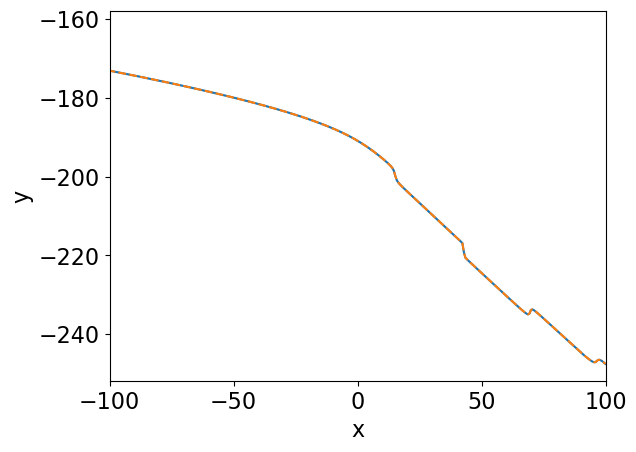

In [303]:
plt.figure()
plt.plot(x, y)
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
# plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, pred, "--")
plt.xlim(-100,100)
plt.xlabel("x")
plt.ylabel("y")
# plt.yscale('log')
plt.show()
plt.close()

In [304]:
max_match(y, pred, x)

1.0000000000000016

# try 2d data set i.e. mass-ratio and times

In [367]:
# def fake_2d_data(n_samples):
#     x = np.sqrt(n_samples / 10.0) * np.random.RandomState(12356).rand(n_samples, 2)
#     yerr = 0.2 * np.ones_like(x[:, 0])
#     y = np.sin(x[:, 0] + x[:, 1]) + yerr * np.random.randn(len(x))
#     return x, y

In [258]:
# x, y = fake_2d_data(100)

In [259]:
# x.shape

(100, 2)

In [201]:
# y.shape

In [202]:
mode = (3,2)
k='q4'
x = nrdatas[k].hlms[mode]['times']
# y = nrdatas[k].hlms[mode]['amp']
y = np.real(nrdatas[k].hlms[mode]['hlm'])

yerr = np.zeros_like(y) + 1e-5

In [203]:
qs = np.ones_like(x) * nrdatas[k].q

In [204]:
# np.array([x, qs]).T

In [205]:
nrdatas[k].q

3.999987396038607

In [206]:
def setup_2d_data(nrdatas, ks = ['q1','q4'], mode=(2,2)):
    firstIteration=True
    for k in ks:
        x = nrdatas[k].hlms[mode]['times']
        y = np.real(nrdatas[k].hlms[mode]['hlm'])
        qs = np.ones_like(x) * nrdatas[k].q
        
        Xtmp = np.array([x, qs]).T
        Ytmp = y
        
        if firstIteration:
            X = Xtmp
            Y = Ytmp
            firstIteration=False
        else:
            X = np.concatenate((X, Xtmp))
            Y = np.concatenate((Y, Ytmp))
    return X, Y

In [207]:
# X, Y = setup_2d_data(nrdatas, ks=['q1','q2','q4'])
# X, Y = setup_2d_data(nrdatas, ks=['q1','q1p2', 'q2','q4'])
X, Y = setup_2d_data(nrdatas, ks=['q1p0','q1p2', 'q2p0','q4p0', 'q7p8'])

In [208]:
X.shape

(2500, 2)

In [209]:
Y.shape

(2500,)

In [210]:
from mpl_toolkits.mplot3d import Axes3D

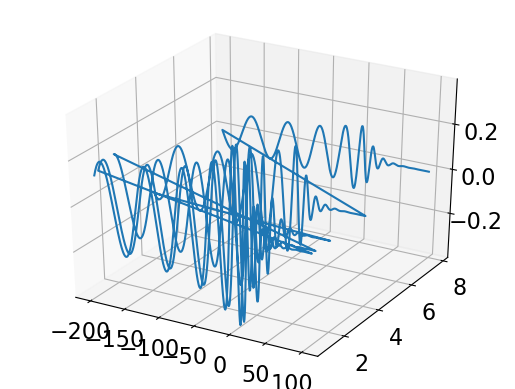

In [211]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:,0], X[:,1], Y)

In [212]:
yerr = np.zeros_like(Y)

In [223]:
from george import kernels

kernel = np.var(Y) * kernels.ExpSquaredKernel(0.5, ndim=2, axes=0)
kernel *= kernels.ExpSquaredKernel(0.5, ndim=2, axes=1)
gp = george.GP(kernel)
gp.compute(X, yerr)

# x_pred = np.linspace(-600, 100, 1000)
# x_pred = x.copy()
# pred, pred_var = gp.predict(y, x_pred, return_var=True)

In [247]:
%%time
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(Y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(Y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(X, yerr)

# Print the initial ln-likelihood.
print(gp.log_likelihood(Y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(Y))

15254.52217396371
24941.43183519966
CPU times: user 3min 53s, sys: 15.8 s, total: 4min 8s
Wall time: 1min 38s


In [248]:
gp.get_parameter_dict()

OrderedDict([('kernel:k1:k1:log_constant', -5.432009091675495),
             ('kernel:k1:k2:metric:log_M_0_0', 2.9407003636240683),
             ('kernel:k2:metric:log_M_0_0', 0.2192910208739714)])

In [249]:
# pred_q = 1
# X_pred = np.array(np.meshgrid(np.linspace(-100, 100, 1000),
#                              np.ones(pred_q)
#                              )).reshape(2,-1).T

In [250]:
q_array = np.linspace(1, 4, 10)
X_pred = np.array(np.meshgrid(np.linspace(-100, 100, 200),
                             q_array
                             )).reshape(2,-1).T

In [251]:
X_pred.shape

(2000, 2)

In [267]:
Y.shape

(2500,)

In [252]:
pred, pred_var = gp.predict(Y, X_pred)

In [253]:
X_pred.shape

(2000, 2)

In [254]:
pred.shape

(2000,)

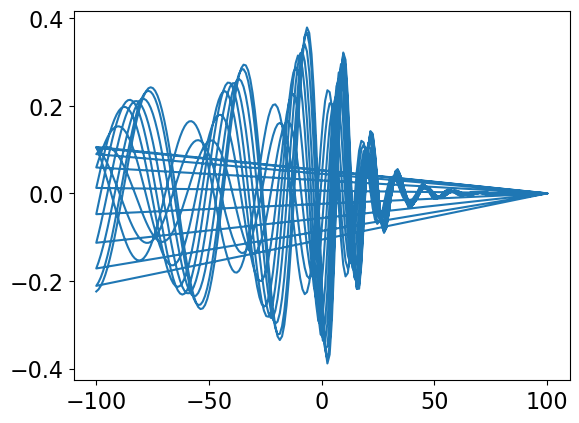

In [255]:
plt.figure()
plt.plot(X_pred[:,0], pred)

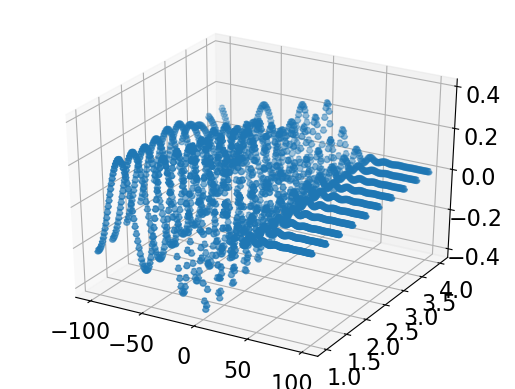

In [256]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X[:,0], X[:,1], Y)
ax.scatter(X_pred[:,0], X_pred[:,1], pred, linestyle='--')

In [257]:
def compare_nr_with_gp(nrdata, gp, q, mode=(2,2)):
    xnr = nrdata.hlms[mode]['times']
    ynr = np.real(nrdata.hlms[mode]['hlm'])
    
    X_pred = np.array(np.meshgrid(xnr,
                                 q
                                 )).reshape(2,-1).T
    
    pred, pred_var = gp.predict(Y, X_pred)
    
    return xnr, ynr, X_pred[:,0], pred

0.8313766122396333


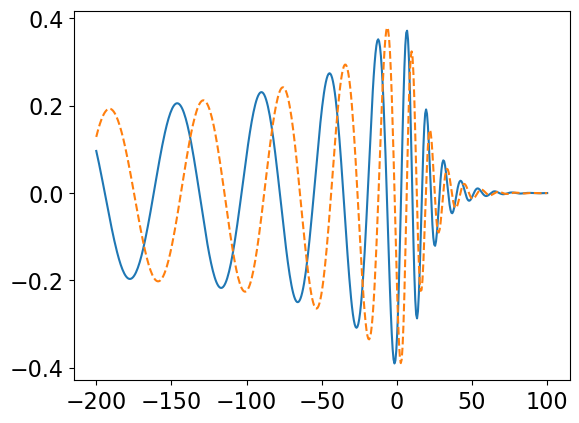

In [258]:
xnr, ynr, xgp, ygp = compare_nr_with_gp(nrdatas['q1'], gp, 1)
print(max_match(ynr, ygp, xgp))
plt.figure()
plt.plot(xnr, ynr)
plt.plot(xgp, ygp, ls='--')

0.9999999999935609


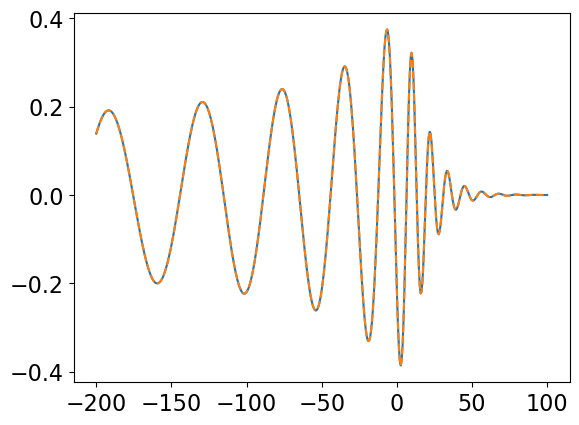

In [259]:
xnr, ynr, xgp, ygp = compare_nr_with_gp(nrdatas['q1p2'], gp, 1.2)
print(max_match(ynr, ygp, xgp))
plt.figure()
plt.plot(xnr, ynr)
plt.plot(xgp, ygp, ls='--')

In [260]:
xnr, ynr, xgp, ygp = compare_nr_with_gp(nrdatas['q2'], gp, 2)
print(max_match(ynr, ygp, xgp))
plt.figure()
plt.plot(xnr, ynr)
plt.plot(xgp, ygp, ls='--')

0.9862559939681981


0.9601422008977016


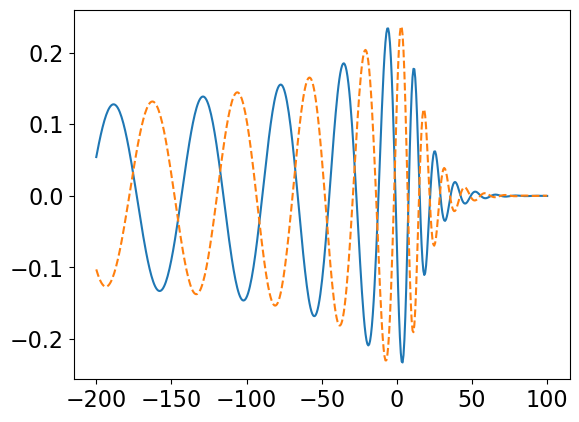

In [261]:
xnr, ynr, xgp, ygp = compare_nr_with_gp(nrdatas['q4'], gp, 4)
print(max_match(ynr, ygp, xgp))
plt.figure()
plt.plot(xnr, ynr)
plt.plot(xgp, ygp, ls='--')

In [262]:
nrdatas['q1']

In [263]:
nrdatas['q1p0']

In [264]:
max_match((nrdatas['q1'].hlms[mode]['hlm']), (nrdatas['q1p0'].hlms[mode]['hlm']), np.real(nrdatas['q1'].hlms[mode]['times']))

0.999595370510417

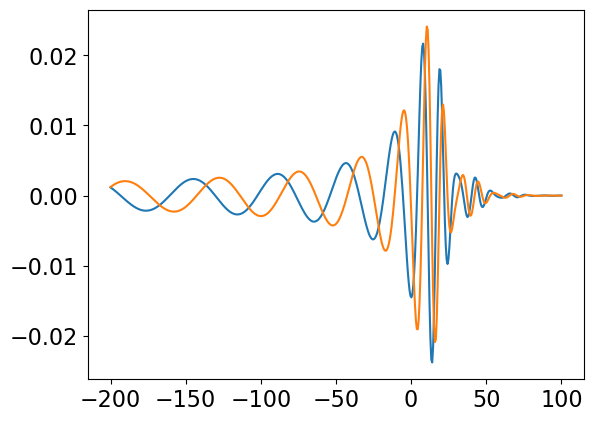

In [265]:
plt.figure()
plt.plot(nrdatas['q1'].hlms[mode]['times'], np.real(nrdatas['q1'].hlms[mode]['hlm']))
plt.plot(nrdatas['q1p0'].hlms[mode]['times'], np.real(nrdatas['q1p0'].hlms[mode]['hlm']))

In [266]:
for k in nrdatas.keys():
    q = nrdatas[k].q
    xnr, ynr, xgp, ygp = compare_nr_with_gp(nrdatas[k], gp, q)
    m = max_match(ynr, ygp, xgp)
    print("[q = {:.3f}]: m = {}".format(q, m))

[q = 1.000]: m = 0.8313766122101197
[q = 2.000]: m = 0.9862556475141385
[q = 4.000]: m = 0.9601429861811073
[q = 5.000]: m = 0.8617499383449276
[q = 10.000]: m = 0.9398286063283208
[q = 1.000]: m = 0.9999999999935878
[q = 1.200]: m = 0.9999999999935609
[q = 1.400]: m = 0.999846089743654
[q = 1.600]: m = 0.9997257643954033
[q = 1.800]: m = 0.9999320394794396
[q = 2.000]: m = 0.9999999999957853
[q = 2.200]: m = 0.999713335870118
[q = 2.400]: m = 0.9965932350379563
[q = 2.600]: m = 0.9904228235087397
[q = 2.800]: m = 0.9813797634252261
[q = 3.000]: m = 0.970892546814741
[q = 3.200]: m = 0.9713630565580644
[q = 3.400]: m = 0.9841434530733958
[q = 3.600]: m = 0.9941871431071334
[q = 3.800]: m = 0.9961512611712511
[q = 4.000]: m = 0.9999999999963938
[q = 4.200]: m = 0.9941445803368824
[q = 4.400]: m = 0.9759410932770387
[q = 4.600]: m = 0.9427936644080506
[q = 4.800]: m = 0.8932369505307672
[q = 5.000]: m = 0.8304207569138771
[q = 5.200]: m = 0.7875484259192631
[q = 5.400]: m = 0.86440453145